## 오토인코더 활용한 신용카드 사기 예측 모델 만들어보기

### 목차
1. 데이터 전처리 프로셋스
    1. Feature 확인
    2. Feature 선택
    3. Feature 정제
    
2. 모델 만들고 학습하기
    1. 모델에 들어갈 데이터셋 만들기
    2. 모델 정의하기 - 오토인코더란?
    3. 학습하기
    
3. 모델 성능 평가하기
    1. 각종 평가 지표를 활용하여 모델의 성능 평가
   
4. 결과


In [1]:
# 필요한 라이브러리 다운로드
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, auc, roc_curve

In [2]:
%load_ext tensorboard
# TensorBoard를 jupyter notebook에서 실행하기 위한 코드. 
# 이것이 없으면 터미널창에서 실행하여 새로운 브라우저로 실행시켜야함

In [3]:
# 데이터 가져오기. 
raw_data = pd.read_csv("/Users/jk/git/Study/Data/kaggle_dataset/credit_fraud/creditcard.csv")

### 데이터 전처리 프로세스
1. Feature 확인
    1. 컬럼은 어떤 것이 얼마나 있고 타입은 어떻게 되는가
    2. 데이터 라벨 비율 확인
    3. 값의 범위는 어떻게 되는가
2. Feature 선택
    1. 출력에 큰 영향을 주지 않는 Feature를 확인 후 소거
3. Feature 정제
    1. null 확인
    2. outlier가 많은가 : heatmap을 통해 상관관계가 높은 것을 위주로 먼저 처리하기. 
    3. 타입 변경
    4. 정규화 or 표준화 작업

In [4]:
# 1. Feature 확인 - 컬럼의 데이터 갯수, 타입, 데이터 값의 범위, label, 불균형도 확인
# data.info(), data.head(), data.shape, data.라벨.value_counts() 활용
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# 데이터 샘플
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# 데이터의 shape
raw_data.shape

(284807, 31)

In [7]:
# normal : fraud = (284315, 492) 불균형한 데이터 비율(0.17%) 확인
print("전체 데이터 대비 fraud 데이터의 비율 : ", len(raw_data[raw_data.Class == 1]) / len(raw_data) * 100)
raw_data.Class.value_counts()

전체 데이터 대비 fraud 데이터의 비율 :  0.1727485630620034


0    284315
1       492
Name: Class, dtype: int64

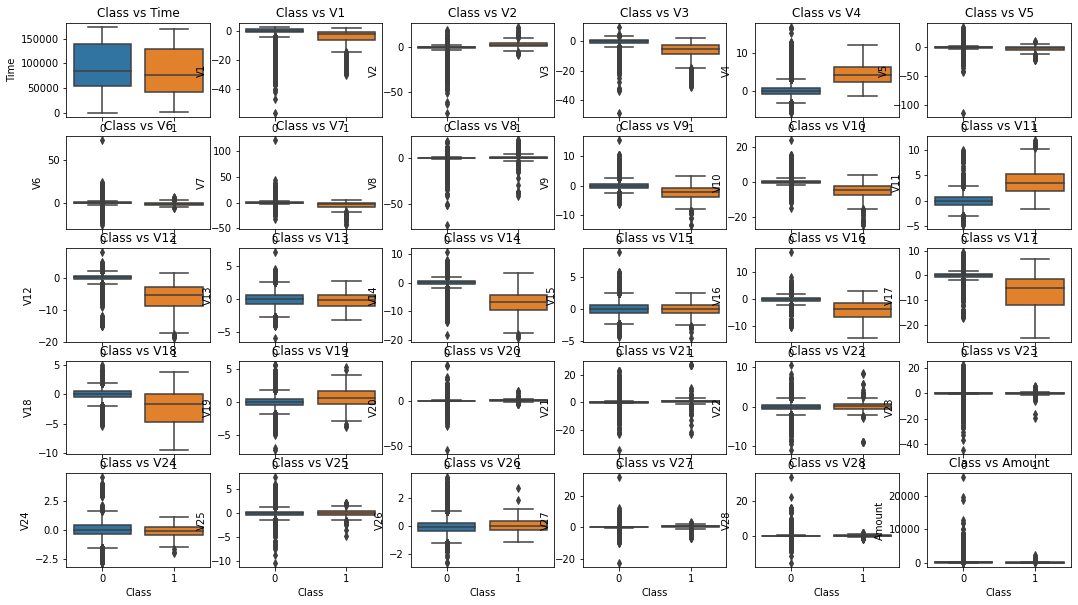

In [8]:
# 데이터 값의 범위 - boxplot() 활용
# Amount와 Time이 극단적으로 높고, 나머지도 컬럼에 따라 범위 변동이 심함. -> 정규화 작업이 필요.
data_cols = raw_data.columns
fig, ax = plt.subplots(5, 6, figsize=(18, 10))
for idx, name in enumerate(data_cols[:-1]):
    i = idx // 6
    j = idx % 6
    sns.boxplot(x="Class", y=name, data=raw_data, ax=ax[i][j])
    ax[i][j].set_title("Class vs " + name)

In [9]:
# 2. Feature 선택 - 출력에 큰 영향을 주지 않는 Feature를 확인 후 소거
show_data1 = raw_data.loc[:, ['Time', 'Amount', 'Class']]

In [10]:
fraud_data = show_data1[show_data1.Class == 1]
normal_data = show_data1[show_data1.Class == 0]

Text(0, 0.5, 'Amount')

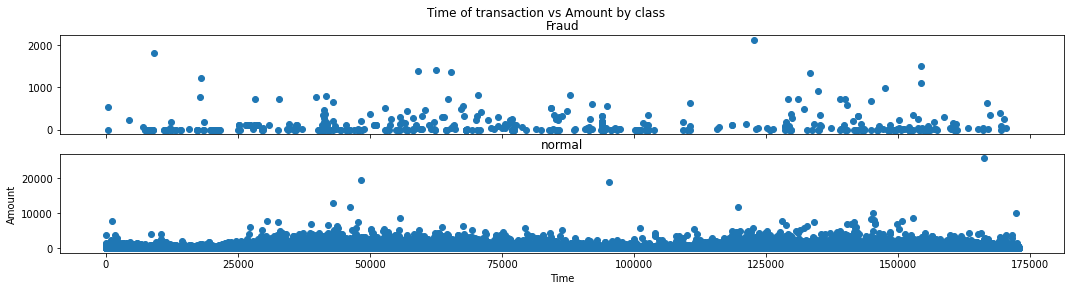

In [11]:
# normal 데이터와 fraud 데이터의 분포 살펴보기.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 4))
fig.suptitle('Time of transaction vs Amount by class')

axes[0].scatter(x=fraud_data.Time, y=fraud_data.Amount)
axes[0].set_title("Fraud")

axes[1].scatter(x=normal_data.Time, y=normal_data.Amount)
axes[1].set_title("normal")

plt.xlabel("Time")
plt.ylabel("Amount")

/Users/jk/setup/anaconda3/envs/python_pro2net/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jk/setup/anaconda3/envs/python_pro2net/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


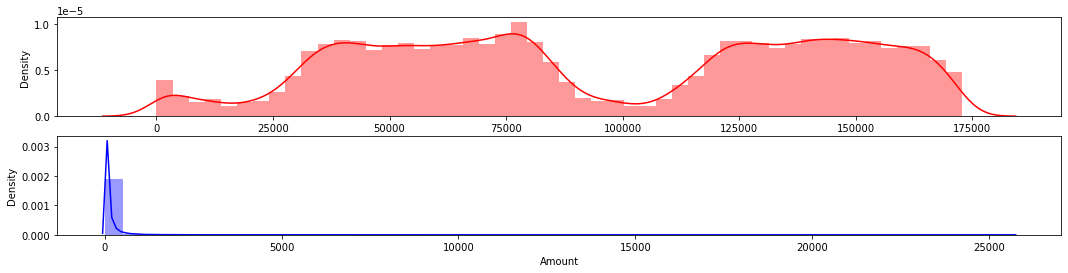

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(18, 4))

sns.distplot(show_data1.Time, ax=ax[0], color="r")

sns.distplot(show_data1.Amount, ax=ax[1], color="b")

plt.show()

Text(0.5, 1.0, 'Amount vs Class')

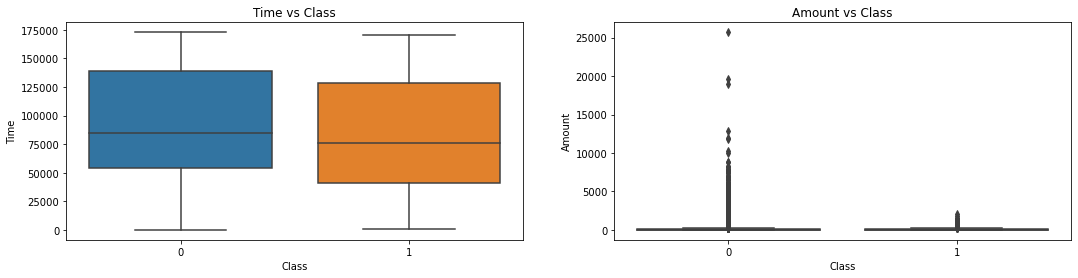

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.boxplot(x="Class", y="Time", data=show_data1, ax=ax[0])
ax[0].set_title("Time vs Class")

sns.boxplot(x="Class", y="Amount", data=show_data1, ax=ax[1])
ax[1].set_title("Amount vs Class")

In [14]:
# boxplot을 살펴보면 Time 컬럼이 normal과 fraud의 비율에 차이가 별로 없다.
# 따라서 Time 컬럼은 삭제
raw_data = raw_data.drop("Time", axis=1)

In [15]:
# 3. Feature 정제 - null 확인
raw_data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<AxesSubplot:title={'center':'heatmap for variable'}>

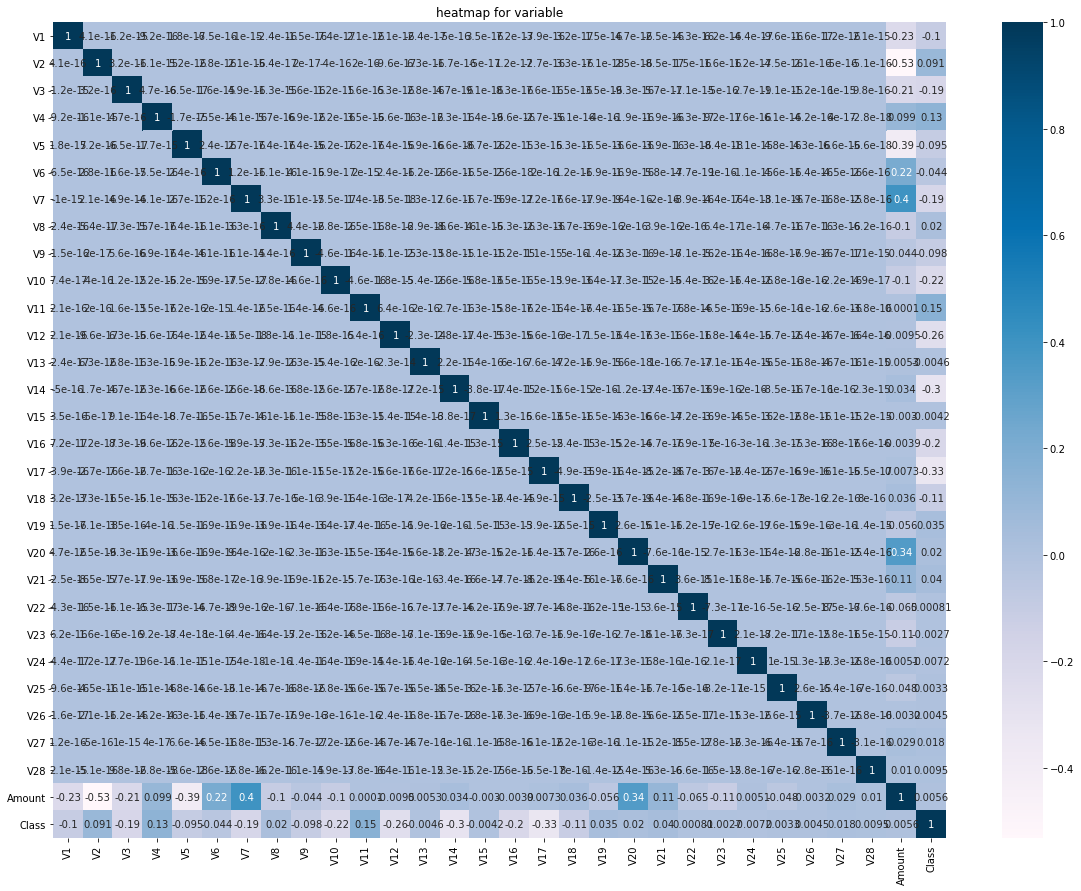

In [16]:
# 3. Feature 정제 - outlier 제거, seaborn.heatmap(), np.percentile() 활용
# 모든 컬럼을 제거하면 데이터의 손실이 크므로 상관관계를 파악해서 가장 높은 상관관계의 두개의 컬럼의 outlier를 제거.
# 각 변수사이의 상관관계를 확인하고자 히트맵 그리기
plt.figure(figsize=(20, 15))           
plt.title("heatmap for variable")

sns.heatmap(raw_data.corr(), linecolor="white", cmap=plt.cm.PuBu, annot=True)    # 그림그리기.

In [17]:
# outlier 제거. 가장 상관계수가 높은 두 컬럼 V14(-0.3), V17(-0.33)의 outlier 제거
# 기준은 boxplot의 upper_bound or lower_bound를 넘어가는 수치를 제거. 다만 Fruad 데이터는 적으므로 Normal 데이터의 outlier를 삭제

def remove_outlier(data, col_name):
    new_data = data.copy()
    Q1, Q3 = np.percentile(new_data[col_name], [25, 75])
    IQR_15 = (Q3 - Q1)*1.5
    upper_bound = Q3 + IQR_15
    lower_bound = Q1 - IQR_15
    new_data = new_data[((new_data.Class == 0) & (new_data[col_name] > lower_bound) & (new_data[col_name] < upper_bound)) | (new_data.Class == 1)]
    return new_data
    

In [18]:
new_data = remove_outlier(raw_data, "V14")
new_data = remove_outlier(new_data, "V17")
print("제거된 숫자", len(raw_data) - len(new_data))   # 제거된 숫자 17282

제거된 숫자 17282


In [19]:
# 3. Feature 정제 - 정규화 or 표준화 작업 - RobustScaler(), MinMaxScaler() 활용
# Amount 같은 경우 값도 크고 outlier도 많아서 robust scaling을 먼저 진행
# RobustScaling
robust_scaler = RobustScaler()
scale_data = new_data.copy()

# robust_scaler
scale_data["Amount"] = robust_scaler.fit_transform(scale_data["Amount"].values.reshape(-1, 1))

In [20]:
# 모든 데이터의 범위를 0 ~ 1로 맞추기
# MinMax
def minmax_scaling(data, col_name):
    mmsc = MinMaxScaler()
    new_col = mmsc.fit_transform(data[col_name].values.reshape(-1, 1))
    return new_col

In [21]:
col_names = scale_data.columns[:-1]
scale_data2 = scale_data.copy()

for name in col_names:
    new_col = minmax_scaling(scale_data, name)
    scale_data2[name] = new_col


## 모델 만들고 학습하기
1. 모델에 들어갈 데이터셋 만들기
    1. 필요할시 데이터 인코딩 작업 진행(주로 범주형 데이터에 한해)
    2. 데이터 input 타입이 확인. 데이터가 tf.data.Dataset 종류이면 numpy와 다른점이 존재하므로 학습시킬때 유의.
    3. 데이터 분할 및 셔플

2. 모델 정의하기.
    1. 하이퍼파라미터(batch size, input_dim 등) 정의
    2. 뉴럴 네트워크 구성하기
    3. metrics, callback 함수 등 구성하기

3. 학습하기.
    1. model.fit() 형태로 학습하기
    2. checkpoint, SavedModel 형식으로 모델을 저장
    3. 텐서보드로 학습이 잘 되었는지 확인

In [22]:
# 1. 모델에 들어갈 데이터셋 만들기 - 데이터 분할 및 셔플, np.split(), df.sample() 활용
# 정상과 비정상 데이터를 구분한 후 정상데이터를 6:2:2로 구분(train:val:test)
# 비정상 데이터의 경우 5:5로 나누어 val와 test 데이터에 분배 후 각 데이터셋 셔플

# 정상과 비정상 데이터로 분할
nor_dataset = scale_data2[scale_data2.Class == 0]
abnor_dataset = scale_data2[scale_data2.Class == 1]

# 정상, 비정상 데이터를 6:2:2로 분할
train_nor_dataset, val_nor_dataset, test_nor_dataset = np.split(nor_dataset, [int(0.6*len(nor_dataset)), int(0.8*len(nor_dataset))])

# print(len(train_nor_dataset) / len(nor_dataset), len(val_nor_dataset) / len(nor_dataset), len(test_nor_dataset) / len(nor_dataset))
# print(len(val_abnor_dataset) / len(abnor_dataset), len(test_abnor_dataset) / len(abnor_dataset))

In [23]:
# 데이터 병합 - merge 및 셔플
train_dataset = train_nor_dataset.sample(frac=1.0, random_state=152).reset_index(drop=True)
val_dataset = val_nor_dataset.sample(frac=1.0, random_state=151).reset_index(drop=True)
test_dataset = test_nor_dataset.append(abnor_dataset).sample(frac=1.0, random_state=152).reset_index(drop=True)

print(len(train_dataset) / len(scale_data2) * 100)
print(len(val_dataset) / len(scale_data2) * 100)
print(len(test_dataset) / len(scale_data2) * 100)

# 각 데이터 비율 : 59.8893, 19.9633, 20.1472
train_dataset = train_dataset.drop("Class", axis=1)
val_dataset = val_dataset.drop("Class", axis=1)
train_dataset.shape

59.88935613494066
19.963367909541162
20.147275955518175


(160219, 29)

In [24]:
# 2. 모델 정의하기 - 하이퍼파라미터 정의

input_dim = train_dataset.shape[1]
latent_dim = 4
learning_rate = 0.0000001
batch_size = 64
nb_epoch = 50
inputs = tf.keras.layers.Input(shape=(input_dim,))
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))


### 오토인코더란?

입력과 출력이 같은 형태를 가지는 모델을 오토인코더라고 부른다. 다음과 같은 4가지 특징을 지닌다.
1. 비지도 학습
2. Maniford learning(차원 축소 학습)
3. Generative model learning(축소된 차원을 되돌리는 학습)
4. ML density estimation(loss가 가장 낮은 것이 좋은 것으로 해석. 최솟값을 찾으려고함.)

### 오토인코더의 형태
![autoencoder](./image/2.png)

### 기존의 PCA 같은 방법론에 비해 오토인코더는 무엇이 다른가?
기존의 방법론들은 neighborhood base 방법이다 보니 고차원 데이터 간의 유클리디안 거리는 유의미한 거리 개념이 아닐 가능성이 있지만 오토인코더는 데이터가 많을수록, 고차원 데이터일수록 성능이 좋다.


In [25]:
# 2. 모델 정의하기 - 뉴럴 네트워크 구성하기, Keras functional API를 활용(상황에 따라 subclassing 활용가능)
# 기본적인 뉴럴 네트워크인 Dense를 활용. layer 개수 : 30, 14, 7, 14, 30
# 오버 피딩을 방지하기위해 가중치 페널티 activity_regularizer 와 Dropout을 적용.
# encoder 부분
def create_encoder(inputs):
    x = tf.keras.layers.Dense(14, activation="tanh", 
                              activity_regularizer=tf.keras.regularizers.l2(learning_rate))(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(7, activation="relu")(x)
    latent = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
    return latent

# decoder 부분
def create_decoder(latent_vector):
    x = tf.keras.layers.Dense(7, activation="relu")(latent_vector)
    x = tf.keras.layers.Dense(14, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(input_dim, activation="tanh")(x)
    return outputs

encoder = tf.keras.models.Model(inputs=inputs, outputs=create_encoder(inputs), name="ae_encoder")
decoder = tf.keras.models.Model(inputs=latent_inputs, outputs=create_decoder(latent_inputs), name="ae_decoder")
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=decoder(encoder(inputs)), name="autoencoder_basic")
autoencoder.summary()

Model: "autoencoder_basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
ae_encoder (Functional)      (None, 4)                 557       
_________________________________________________________________
ae_decoder (Functional)      (None, 29)                582       
Total params: 1,139
Trainable params: 1,139
Non-trainable params: 0
_________________________________________________________________


In [26]:
# 2. 모델 정의하기 - metrics, callback 함수 등 구성하기
# 콜백 함수 정리. checkpoint, early stoppinng, tensorboard
# mode = monitor값이 min or max으로 할건지 선택. 디폴트는 auto
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_basic",
                                       mode="min", monitor="val_loss",
                                       verbose=2, save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

log_dir = "ae_basic_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


autoencoder.compile(metrics=['acc'],
                   loss="mean_squared_error",
                   optimizer='adam')


In [27]:
# 3. 모델 학습하기 - model.fit() 활용
history = autoencoder.fit(train_dataset, train_dataset,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle=False,
                         validation_data=(val_dataset, val_dataset),
                         verbose=1,
                         callbacks=[cp, early_stop, tensorboard]
                         ).history

Epoch 1/50
2504/2504 [==============================] - 3s 1ms/step - loss: 0.0193 - acc: 0.5078 - val_loss: 0.0026 - val_acc: 0.9233

Epoch 00001: val_loss improved from inf to 0.00264, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 2/50
2504/2504 [==============================] - 2s 951us/step - loss: 0.0035 - acc: 0.8051 - val_loss: 0.0026 - val_acc: 0.9233

Epoch 00002: val_loss improved from 0.00264 to 0.00260, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 3/50
2504/2504 [==============================] - 2s 948us/step - loss: 0.0023 - acc: 0.8233 - val_loss: 0.0020 - val_acc: 0.9233

Epoch 00003: val_loss improved from 0.00260 to 0.00200, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 4/50
2504/2504 [==============================] - 2s 945us/step - loss: 0.0017 - acc: 0.8265 - val_loss: 0.0017 - val_acc: 0.9233

Epoch 00

In [28]:
# 3. 모델 학습하기 - 모델 저장하기. 
autoencoder.save("model")

INFO:tensorflow:Assets written to: model/assets


In [35]:
%tensorboard --logdir ae_basic_logs/fit/20211008-014939

![tensorboard_image](./image/1.png)

## 모델 성능 평가
1. 각종 평가 지표를 활용하여 모델의 성능 평가
    1. 잔차에 따른 데이터 분포 확인
    2. threshold 값을 변경하면서 모델의 최대 성능 확인

*오토인코더의 경우 input과 output의 loss인 Reconstruction_error를 바탕으로 평가. 이번 프로젝트의 경우엔 두 값의 비교를 mse로 할 예정

In [30]:
# 1. 각종 평가 지표를 활용하여 모델의 성능 평가 - 잔차에 따른 데이터 분포 확인
test_dataset_label = test_dataset["Class"]
test_dataset_data = test_dataset.drop("Class", axis=1)


pred = autoencoder.predict(test_dataset_data)
mse = np.mean(np.power(test_dataset_data-pred, 2), axis=1)
error_df = pd.DataFrame({"Reconstruction_error": mse,
                        "True_class": test_dataset_label})
error_df

,Reconstruction_error,True_class
0,0.001116,0
1,0.000710,0
2,0.001045,0
3,0.002247,0
4,0.001967,0
...,...,...
53894,0.000617,0
53895,0.000744,0
53896,0.001176,0
53897,0.000831,0


Text(0.5, 0, 'Data point index')

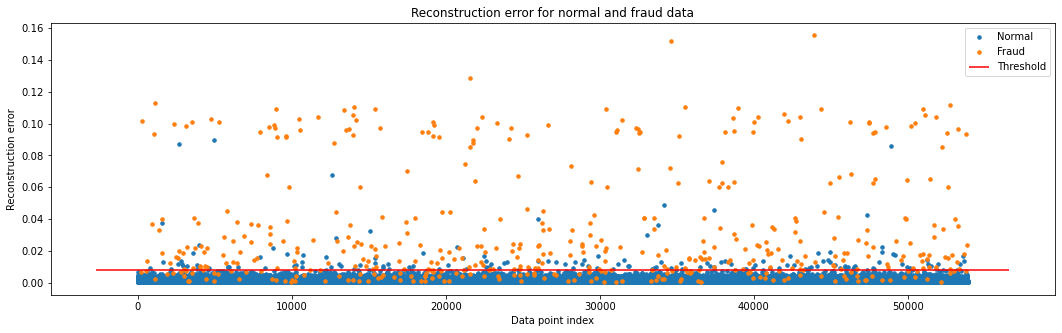

In [46]:
# 1. 각종 평가 지표를 활용하여 모델의 성능 평가 - 잔차에 따른 데이터 분포 확인
th = 0.008

true_group = error_df.groupby("True_class")
true_group
fig, ax = plt.subplots(figsize=(18, 5))
for name, group in true_group:
    ax.plot(group.index, group.Reconstruction_error, marker="o", ms=3.5, linestyle='',
           label="Fraud" if name == 1 else "Normal")
ax.hlines(th, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")


Accuracy :  0.9947494387650977
Recall :  0.7357723577235772
Precision :  0.7029126213592233
f1_score :  0.7189672293942402
auc :  0.958905504150441


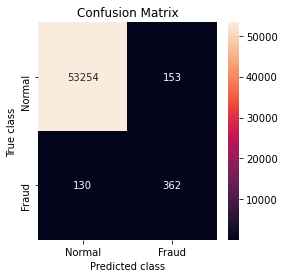

In [47]:
# 1. 각종 평가 지표를 활용하여 모델의 성능 평가 - threshold 값을 변경하면서 모델의 최대 성능 확인
LABELS = ["Normal", "Fraud"]
pred_y = [1 if e > th else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
fpr, tpr, th = roc_curve(error_df.True_class, error_df.Reconstruction_error)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

print("Accuracy : ", accuracy_score(error_df["True_class"], error_df["pred"]))
print("Recall : ", recall_score(error_df["True_class"], error_df["pred"]))
print("Precision : ", precision_score(error_df["True_class"], error_df["pred"]))
print("f1_score : ", f1_score(error_df["True_class"], error_df["pred"]))
print("auc : ", auc(fpr, tpr))    # 0.9589

# th : recall, f1_score
# 0.009 : 0.6849, 0.7020 
# 0.008 : 0.7357, 0.7189 130 / 362
# 0.007 : 0.7723, 0.7043
# 0.006 : 0.8130, 0.6509 92 / 400


## 결과
최종적으로 Threshold가 0.008일 때, Recall = 0.7357 F1_score = 0.7189, Auc = 0.9589 로 F1-score가 가장 높다. 총 이상유저 492명 중 362명을 이상유저(Fraud)로 걸러냈다. 

## 총평
총 이상유저 492명 중 362명을 이상 유저로 걸러냈다. 여기서 텐서보드의 학습추이를 보면 이상한 부분이 있다. val_loss가 epoch 8~10지점에서 train_loss 보다 근소하게 높게 나온다. 물론 loss가 너무 낮아서 큰 문제가 안될수도 있지만 오버피팅의 위험이 있는 학습률인 것 같다. 모델의 성능을 더 보완하기 위해 다음과 같은 방법이 추가로 고려될 수 있다.

1. 데이터를 추가하거나, 불필요한 Feature를 더 엄격하게 삭제할 수 있다. 
2. V14, V17외의 다른 컬럼에도 outlier를 제거한다.
3. 모델의 네트워크 깊이를 더 깊게 해본다.
4. 모델의 Dropout 등의 비율을 조정해본다.
5. 모델의 epoch, learning rate 등의 하이퍼 파라미터 값을 조정해본다.
6. 모델의 최적화 함수를 Adam에서 다른 것으로 바꿔본다.
7. 모델을 변경하여 오토인코더의 다른 버전인 Denosing Auto Encoder를 적용해본다.

등을 고려해볼 수 있다. 
